In [3]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal


plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [4]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [47]:
def gaussian_mixer(base):
    def tmp(x, *params):
        mu = np.array(params[slice(0,len(params),3)])
        scale = np.array(params[slice(1,len(params),3)])
        sigma = np.array(params[slice(2,len(params),3)])
        return np.sum(scale * np.exp(-0.5*((x.reshape(-1,1) - mu)/sigma)**2),1) + base
    return tmp

def gaussian(x, mu, sigma, scale):
    x = scale * np.exp(-0.5* ((x - mu) / sigma)**2)
    return x * (x > 1)

def fit_gaussian2(x):    
    best_mu = 0,1,1
    best_intergral = 0
    min_sigma = 150
    max_sigma = 1500
    lst = []
    for mu in np.concatenate((np.linspace(-1000, wavenumbers[0], 10), np.linspace(wavenumbers[0], wavenumbers[-1], 10))):
        temp_mu = 0,1,1
        temp_intergral = 0
        for sigma in np.linspace(min_sigma**0.5, max_sigma**0.5, 100)**2:
            if mu < 0 and mu + 3*sigma < 0:
                continue
            scale = 10
            current = gaussian(wavenumbers, mu, sigma, scale)
            
            for delta in 10**np.arange(10, -1, -1):
                while not np.sum((current - x) > 0):
                    scale += delta
                    current = gaussian(wavenumbers, mu, sigma, scale)
                else:
                    scale -= delta
                    current = gaussian(wavenumbers, mu, sigma, scale)  
                    
            intergral = np.sum(current)           
            if intergral > best_intergral:
                best_intergral = intergral
                best_mu = (mu, sigma, scale)
                print(best_mu, intergral)
                
            if intergral > temp_intergral:
                temp_intergral = intergral
                temp_mu = mu, sigma, scale
             
        plt.plot(gaussian(wavenumbers, *temp_mu), 'b')
        lst.append(gaussian(wavenumbers, *temp_mu))
    plt.plot(x, 'r')
    plt.show()
    lst = np.array(lst)
    return np.max(lst, axis=0)

def preliminary_photo_approximation(x):
    x_ = x
    gaussians = []   
    for _ in range(3):
        current = fit_gaussian2(x_)
        x_ -= current
        gaussians.append(current)
    gaussians = np.array(gaussians)
    return np.sum(gaussians, axis=0)

def fit_gaussian(x):    
    best_mu = 0,1,1
    best_intergral = 0
    min_sigma = 150
    max_sigma = 1500
    for mu in np.concatenate((np.linspace(-1000, wavenumbers[0], 5), np.linspace(wavenumbers[0], wavenumbers[-1], 10))):
        for sigma in np.linspace(min_sigma**0.5, max_sigma**0.5, 20)**2:
            if mu < 0 and mu + 3*sigma < 0:
                continue
            scale = 10
            current = gaussian(wavenumbers, mu, sigma, scale)
            
            for delta in 10**np.arange(10, -1, -1):
                while not np.sum((current - x) > 0):
                    scale += delta
                    current = gaussian(wavenumbers, mu, sigma, scale)
                else:
                    scale -= delta
                    current = gaussian(wavenumbers, mu, sigma, scale)  
                    
            intergral = np.sum(current)           
            if intergral > best_intergral:
                best_intergral = intergral
                best_mu = (mu, sigma, scale)
                print(best_mu, intergral)
                
    print("general done")
    
    old_best_mu = copy.copy(best_mu)
    search_space = 100
    for mu in np.linspace(old_best_mu[0]-search_space, old_best_mu[0]+search_space, 10):
        for sigma in np.linspace(max(min_sigma, old_best_mu[1]-search_space), old_best_mu[1]+search_space, 10):
            scale = 1
            current = gaussian(wavenumbers, mu, sigma, scale)
            
            for delta in 10**np.arange(10, -1, -1):
                while not np.sum((current - x) > 0):
                    scale += delta
                    current = gaussian(wavenumbers, mu, sigma, scale)
                else:
                    scale -= delta
                    current = gaussian(wavenumbers, mu, sigma, scale)  

            intergral = np.sum(current)           
            if intergral > best_intergral:
                best_intergral = intergral
                best_mu = (mu, sigma, scale)
                print(best_mu, intergral)           
       
    print("wide specific area done")

    old_best_mu = copy.copy(best_mu)
    search_space = 10
    for mu in np.linspace(old_best_mu[0]-search_space, old_best_mu[0]+search_space, 10):
        for sigma in np.linspace(max(min_sigma, old_best_mu[1]-search_space), old_best_mu[1]+search_space, 10):
            scale = 1
            current = gaussian(wavenumbers, mu, sigma, scale)
            
            for delta in 10**np.arange(10, -1, -1):
                while not np.sum((current - x) > 0):
                    scale += delta
                    current = gaussian(wavenumbers, mu, sigma, scale)
                else:
                    scale -= delta
                    current = gaussian(wavenumbers, mu, sigma, scale)  

            intergral = np.sum(current)           
            if intergral > best_intergral:
                best_intergral = intergral
                best_mu = (mu, sigma, scale)
                print(best_mu, intergral)   
                
    return best_mu

def split_signal(img):
    x = img[0].reshape(-1, img[0].shape[-1])
    n = np.random.randint(x.shape[0])
#     n = 85
    
#     best_mu = (-300, 150, 150000)
#     plt.plot(wavenumbers, x[n])
#     plt.plot(wavenumbers, gaussian(wavenumbers, *best_mu))
#     plt.show()

    x_ = copy.copy(x[n])
    gaussians = []   
    for _ in range(3):
#         best_mu = fit_gaussian(x_)
#         current = gaussian(wavenumbers, *best_mu)   
        current = fit_gaussian2(x_)
        
        plt.plot(wavenumbers, x_)
        plt.plot(wavenumbers, current)
        plt.show()
        x_ -= current
        gaussians.append(current)
    gaussians = np.array(gaussians)
    
    plt.plot(wavenumbers, x[n])
    plt.plot(wavenumbers, np.sum(gaussians, 0))
    plt.show()
    
#     plt.title("")
#     plt.plot(wavenumbers, x[n], label="raw")
#     plt.legend()
#     plt.show()
    
    
    

    print("pixel:", n)
    

(-1000.0, 338.55712733315966, 701989) 243977.8879133037
(-1000.0, 348.47259835638454, 512035) 251718.49891075125
(-1000.0, 358.5311806339608, 381720) 259866.67207760405
(-1000.0, 368.7328741658887, 290329) 268419.07688126015
(-1000.0, 379.077678952168, 223051) 275064.02726271795
(-1000.0, 389.5655949927989, 173975) 281456.13443621615
(-1000.0, 400.1966222877812, 137924) 288267.36901638785
(-1000.0, 410.97076083711494, 110829) 295036.71472789126
(-1000.0, 421.8880106408003, 90248) 302005.44616660697
(-1000.0, 432.9483716988371, 74446) 309368.65313582675
(-1000.0, 444.15184401122525, 62152) 317123.3146998356
(-1000.0, 455.4984275779651, 52467) 325255.2259868069
(-1000.0, 466.9881223990564, 44750) 333765.69188677537
(-1000.0, 478.620928474499, 38534) 342641.575556895
(-1000.0, 490.3968458042933, 33477) 351878.391031023
(-1000.0, 502.3158743884391, 29324) 361466.46858893713
(-1000.0, 514.3780142269362, 25884) 371407.8059972666
(-1000.0, 526.583265319785, 22955) 380764.3207856829
(-1000.0, 

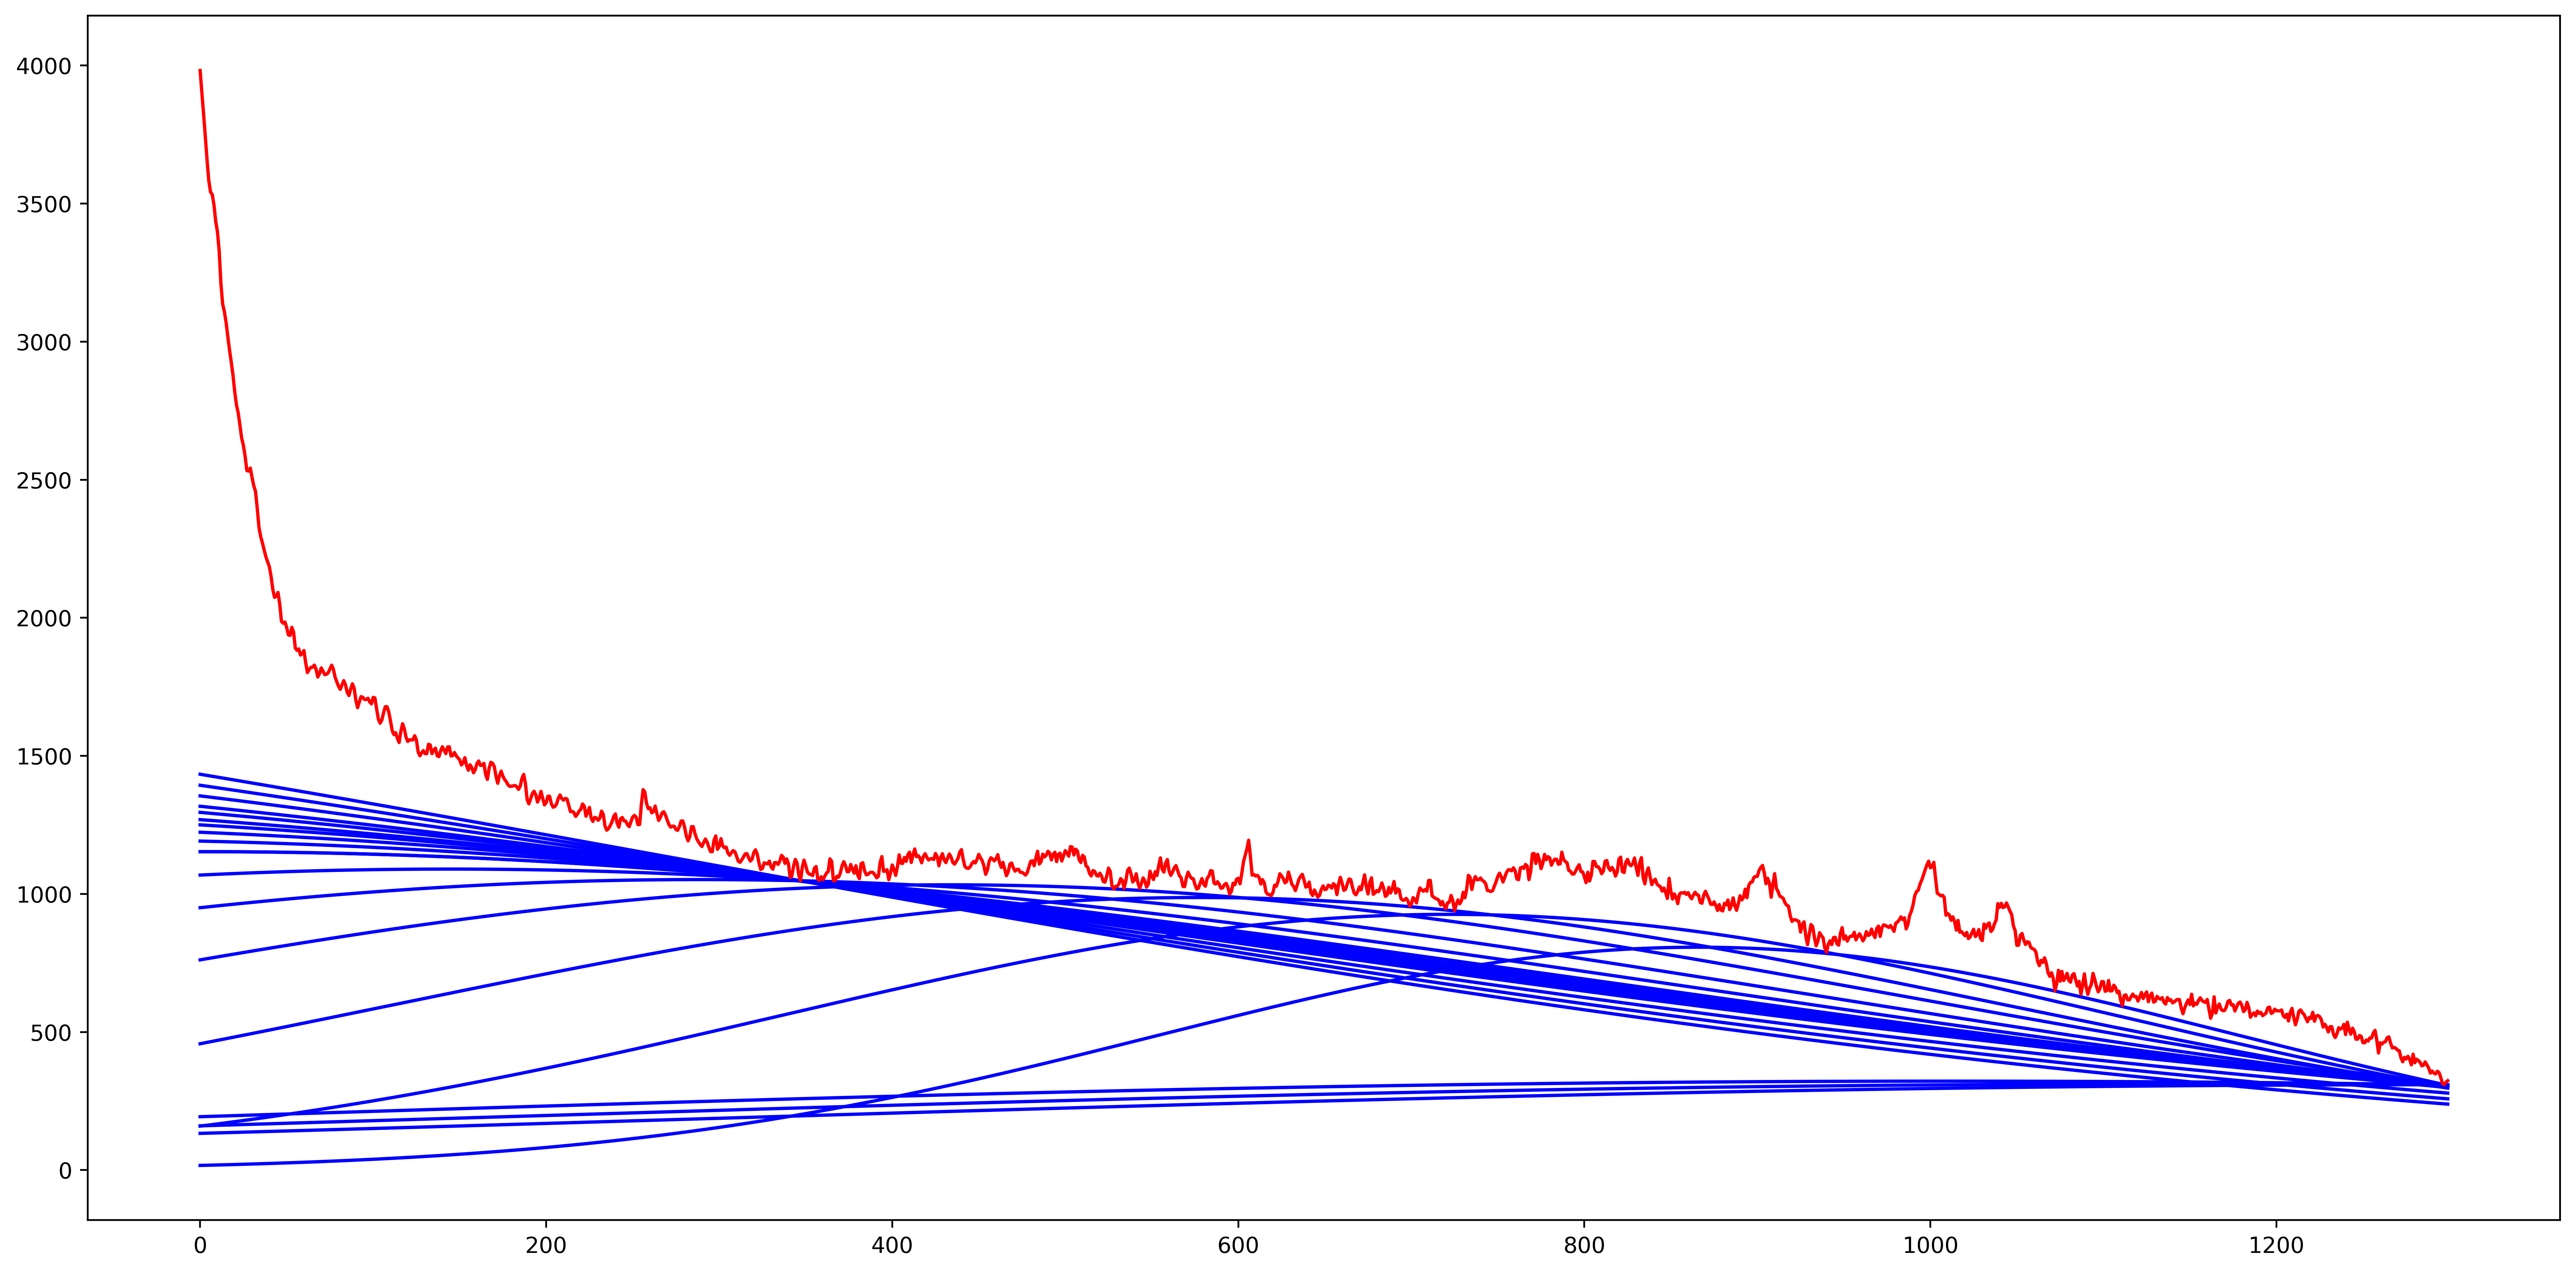

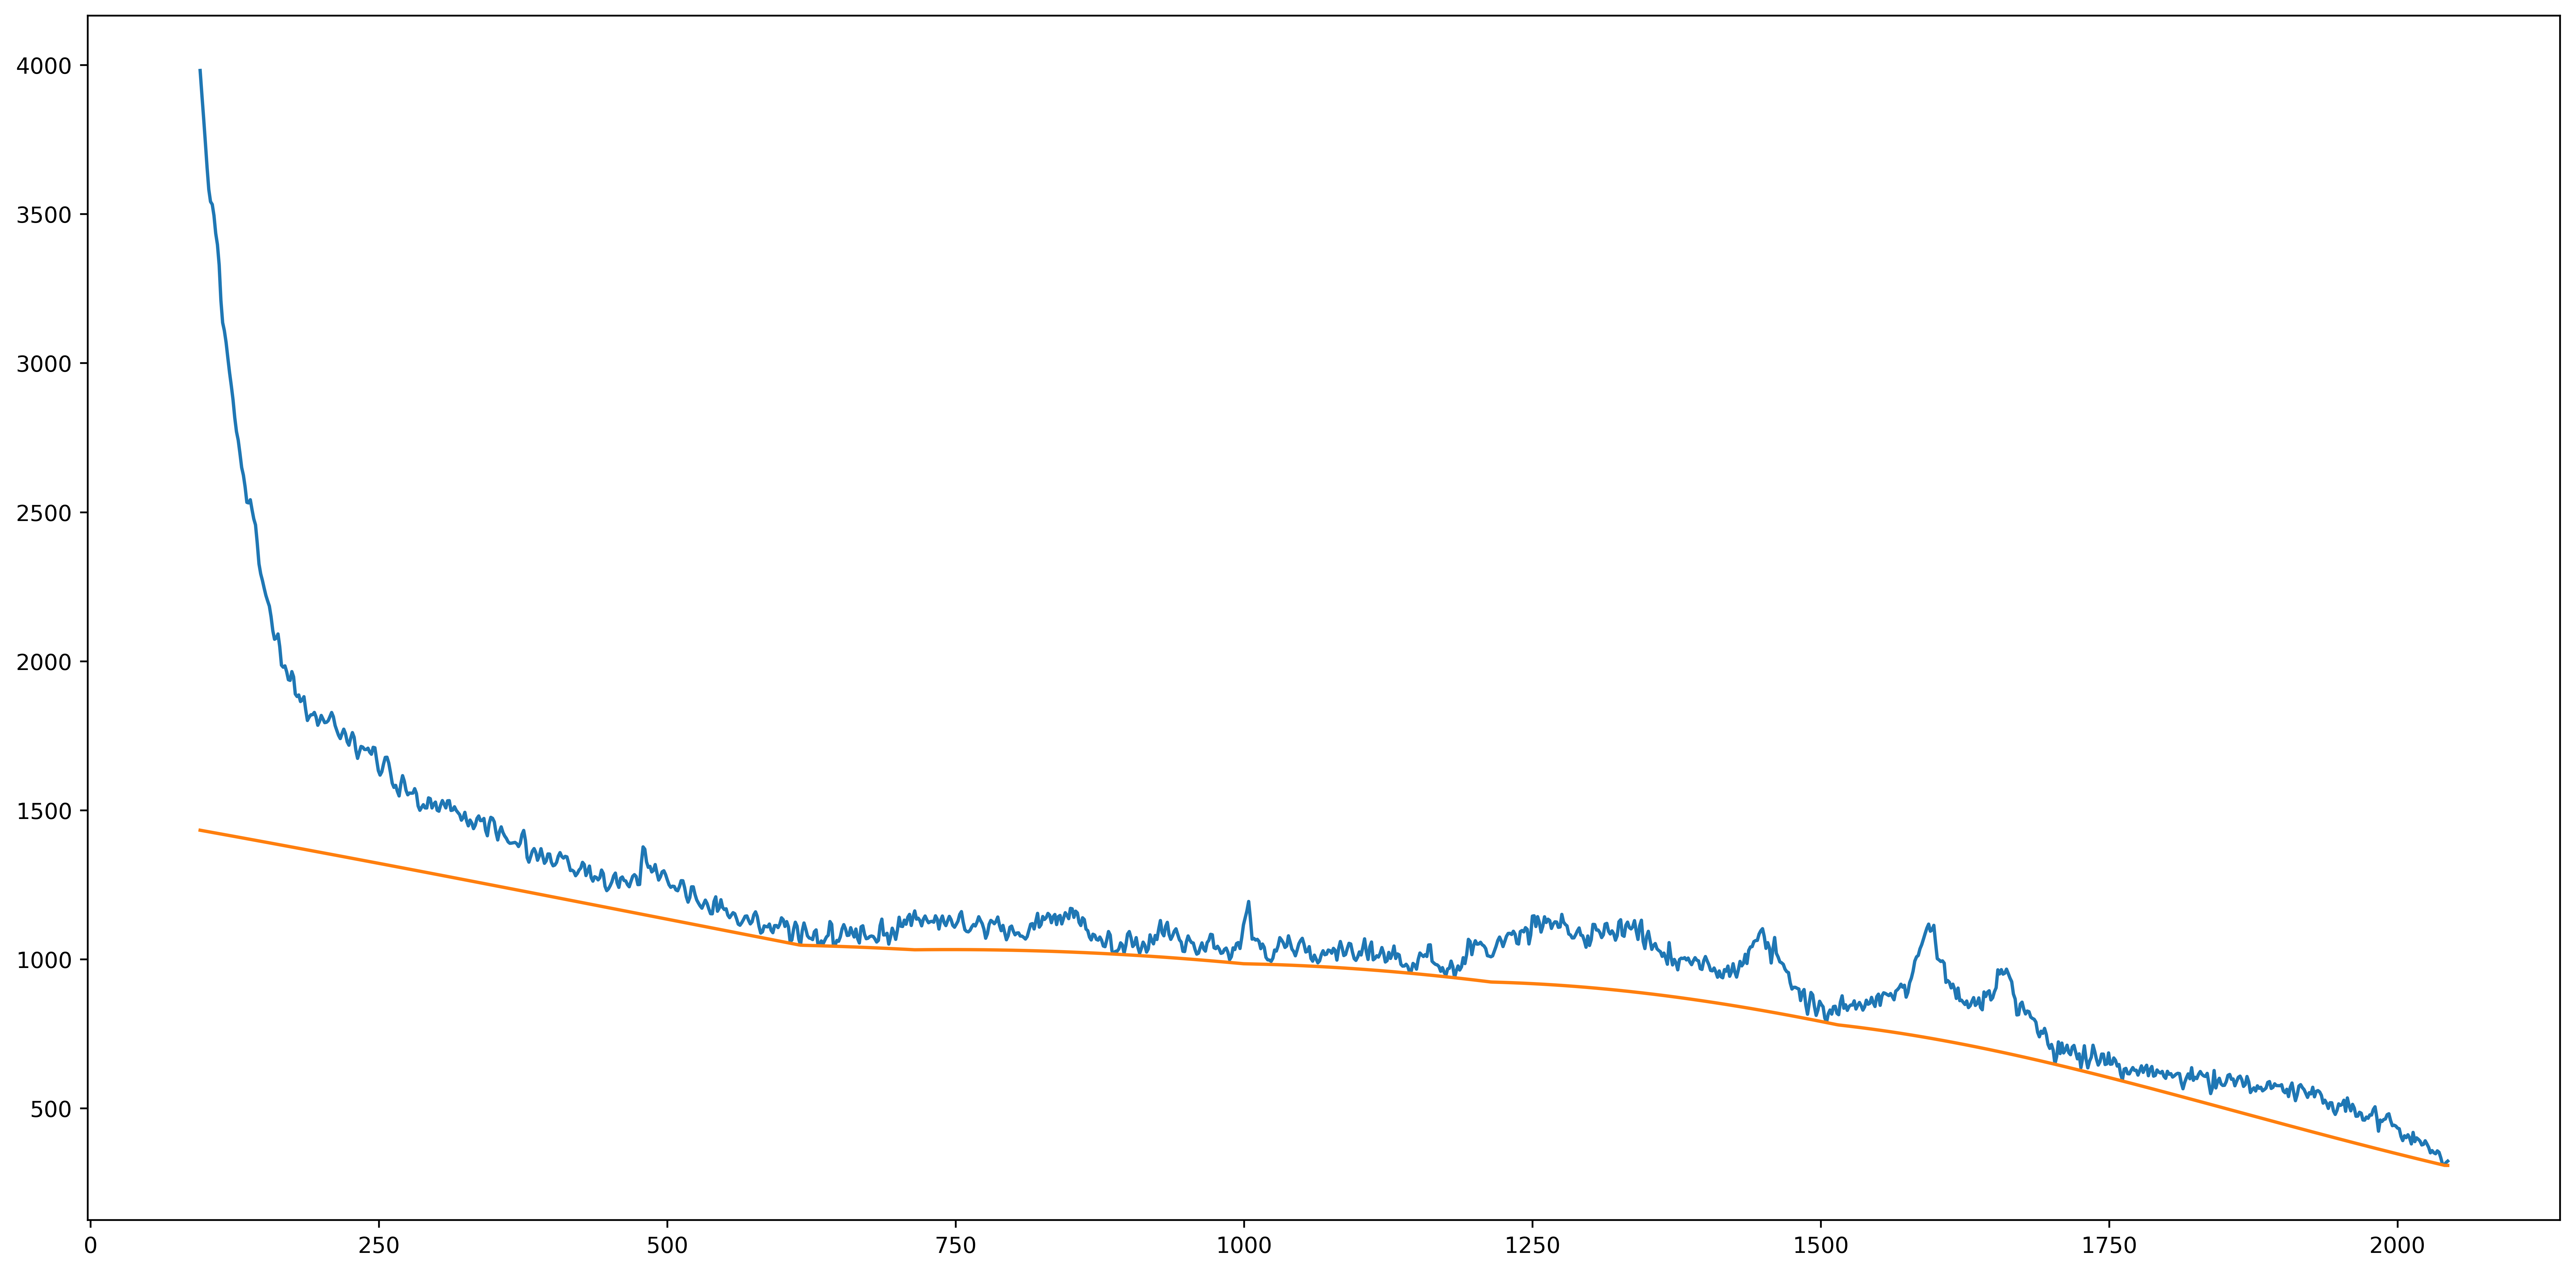

(-1000.0, 338.55712733315966, 87961) 30530.31690543155
(-878.3333333333334, 300.32635578377517, 235744) 71061.93905249742
(-756.6666666666666, 255.75789456995324, 398305) 74676.70644170657
(-635.0, 214.7672147149185, 627277) 77070.77212714712
(-513.3333333333333, 177.3543162186711, 894361) 81211.72697192228


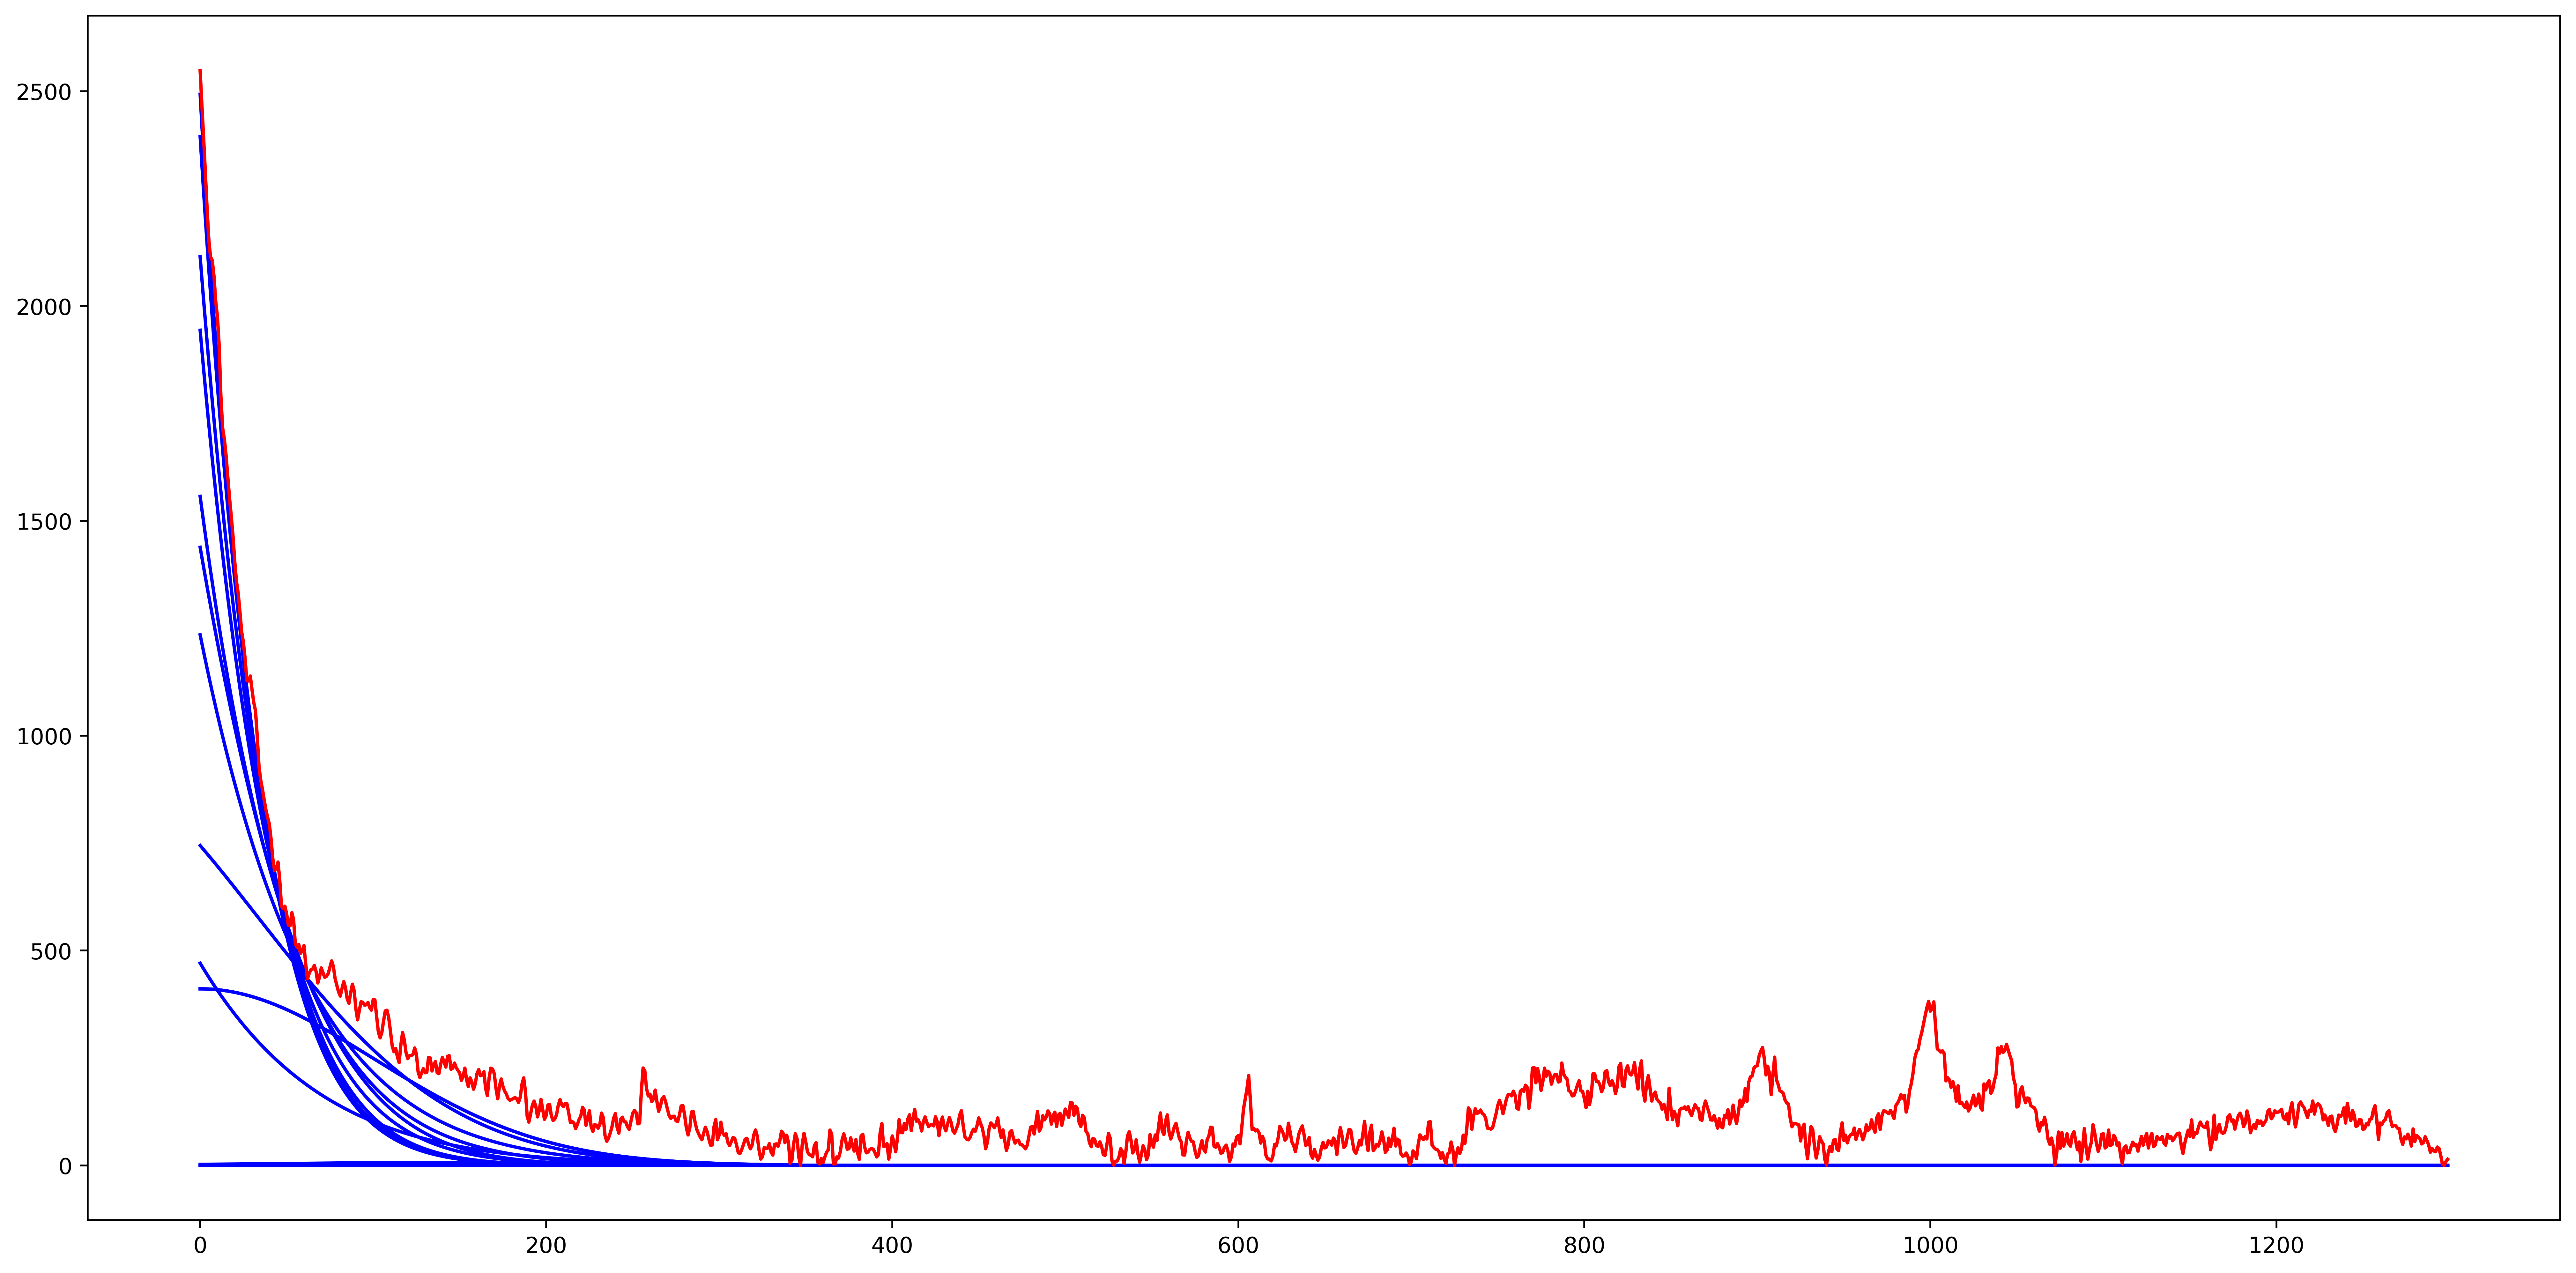

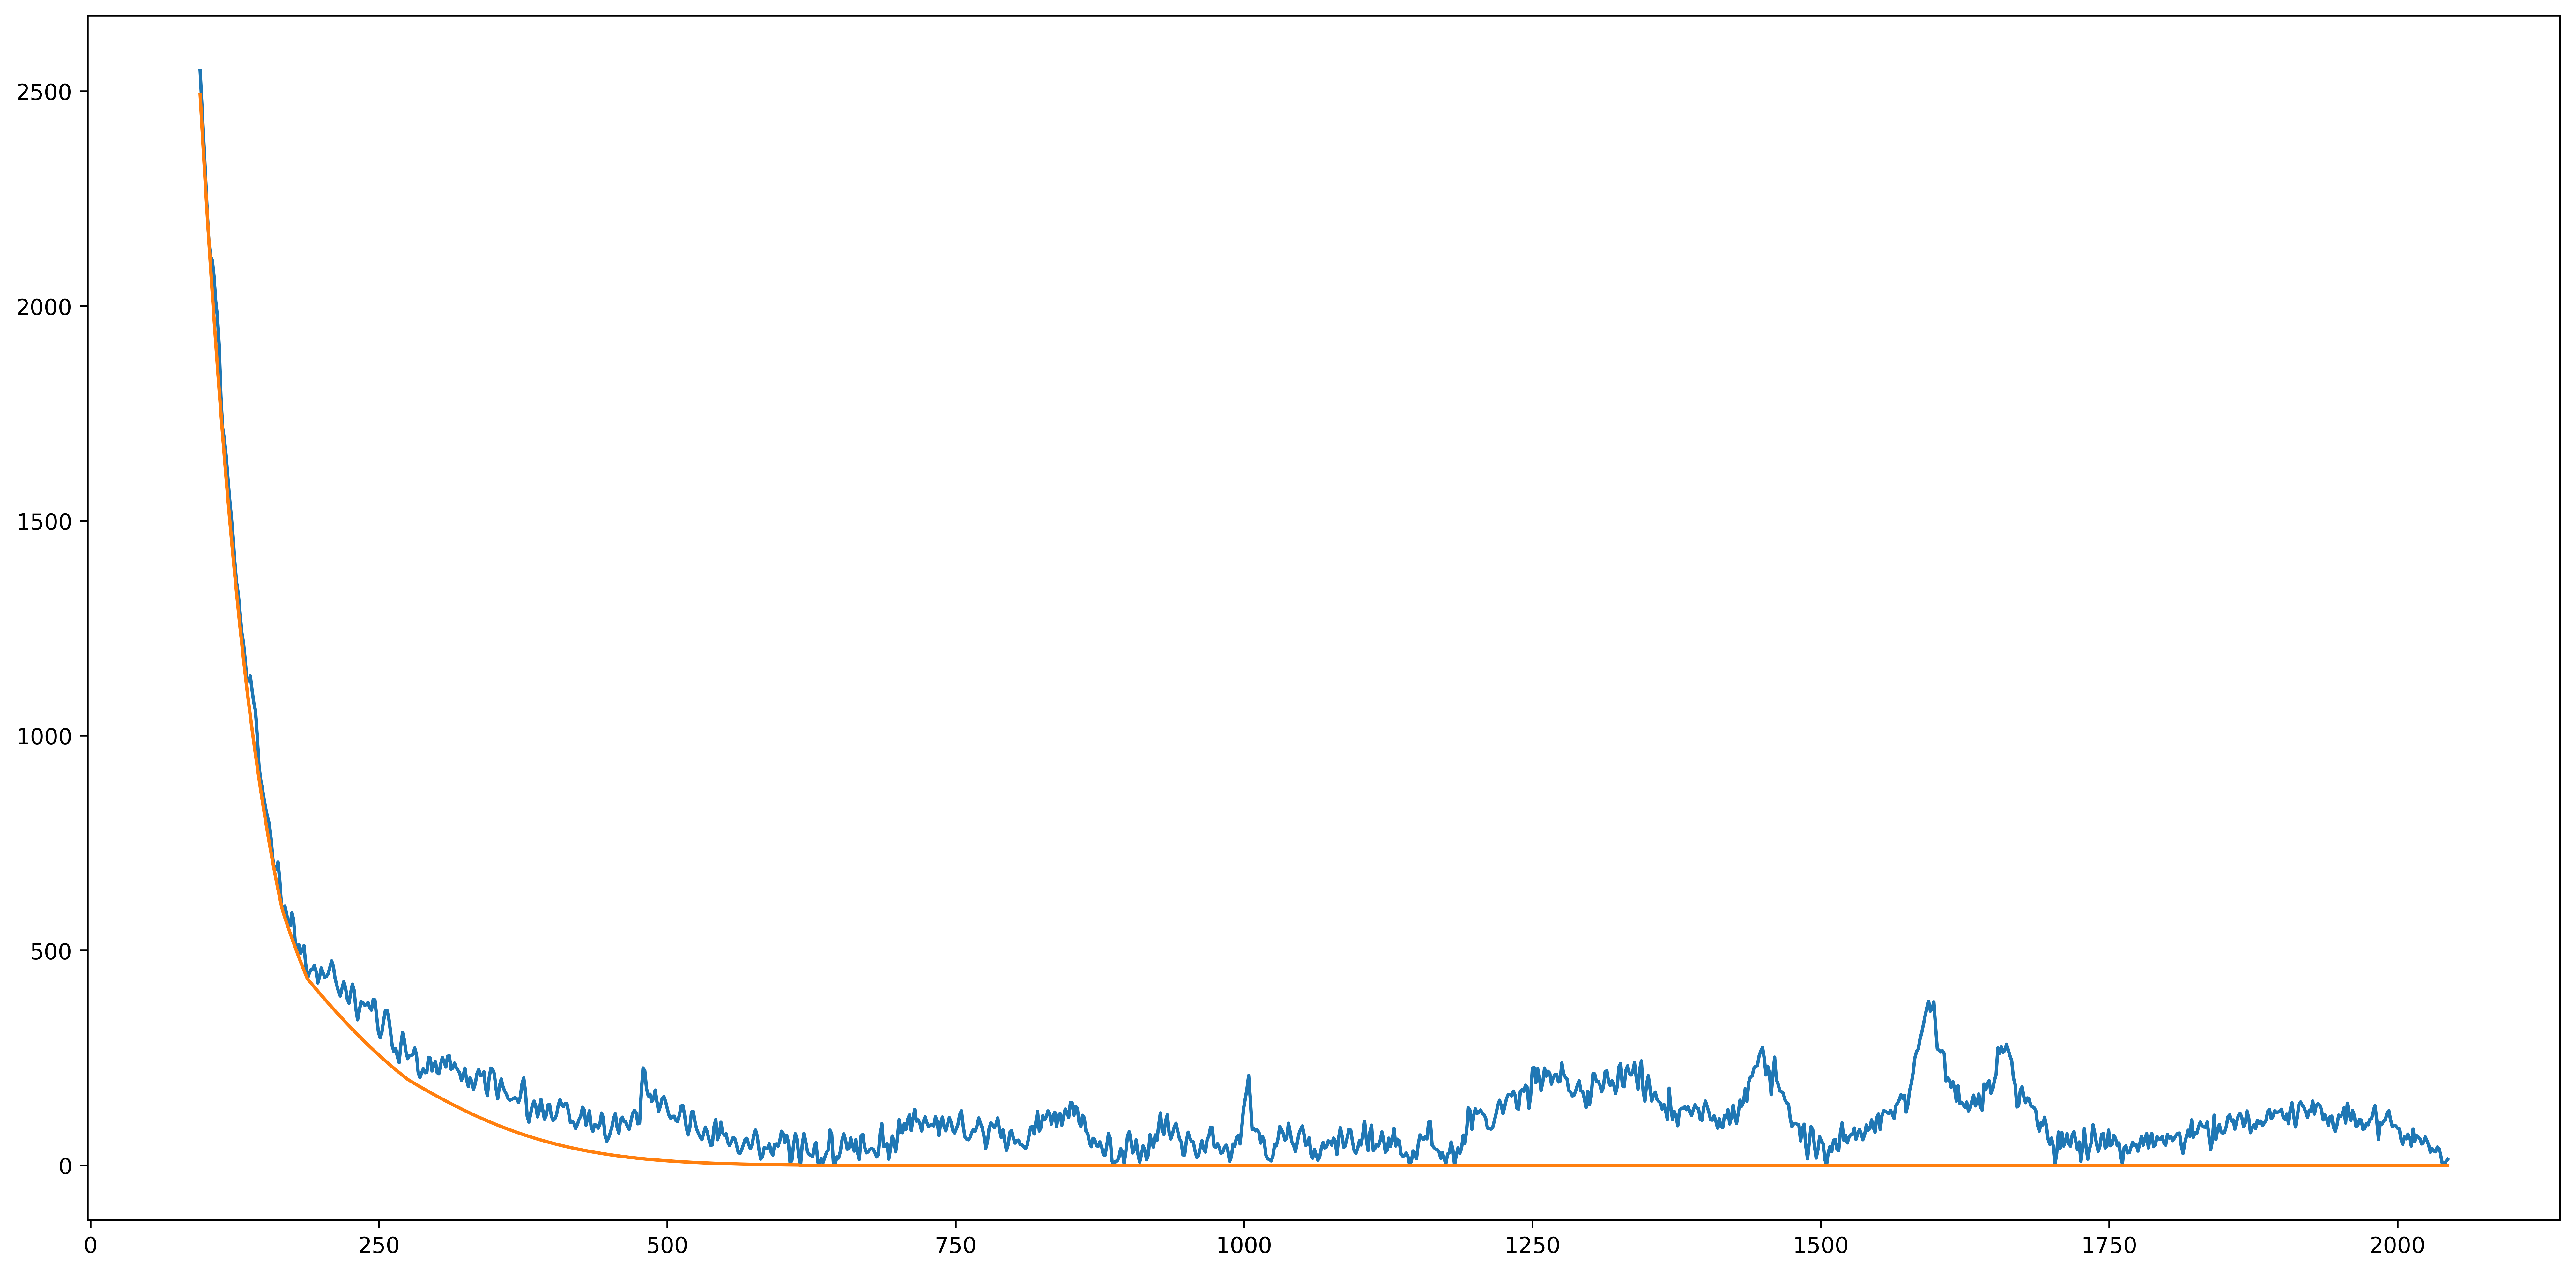

(-1000.0, 338.55712733315966, 200) 5.20099616547795
(-1000.0, 348.47259835638454, 149) 5.20429954252325
(-878.3333333333334, 300.32635578377517, 207) 5.249822010897597
(-756.6666666666666, 255.75789456995324, 282) 5.30265980903261
(-635.0, 214.7672147149185, 363) 5.36600458706437
(-513.3333333333333, 177.3543162186711, 415) 5.461514086232216
(-391.66666666666663, 150.0, 227) 5.512699922536013


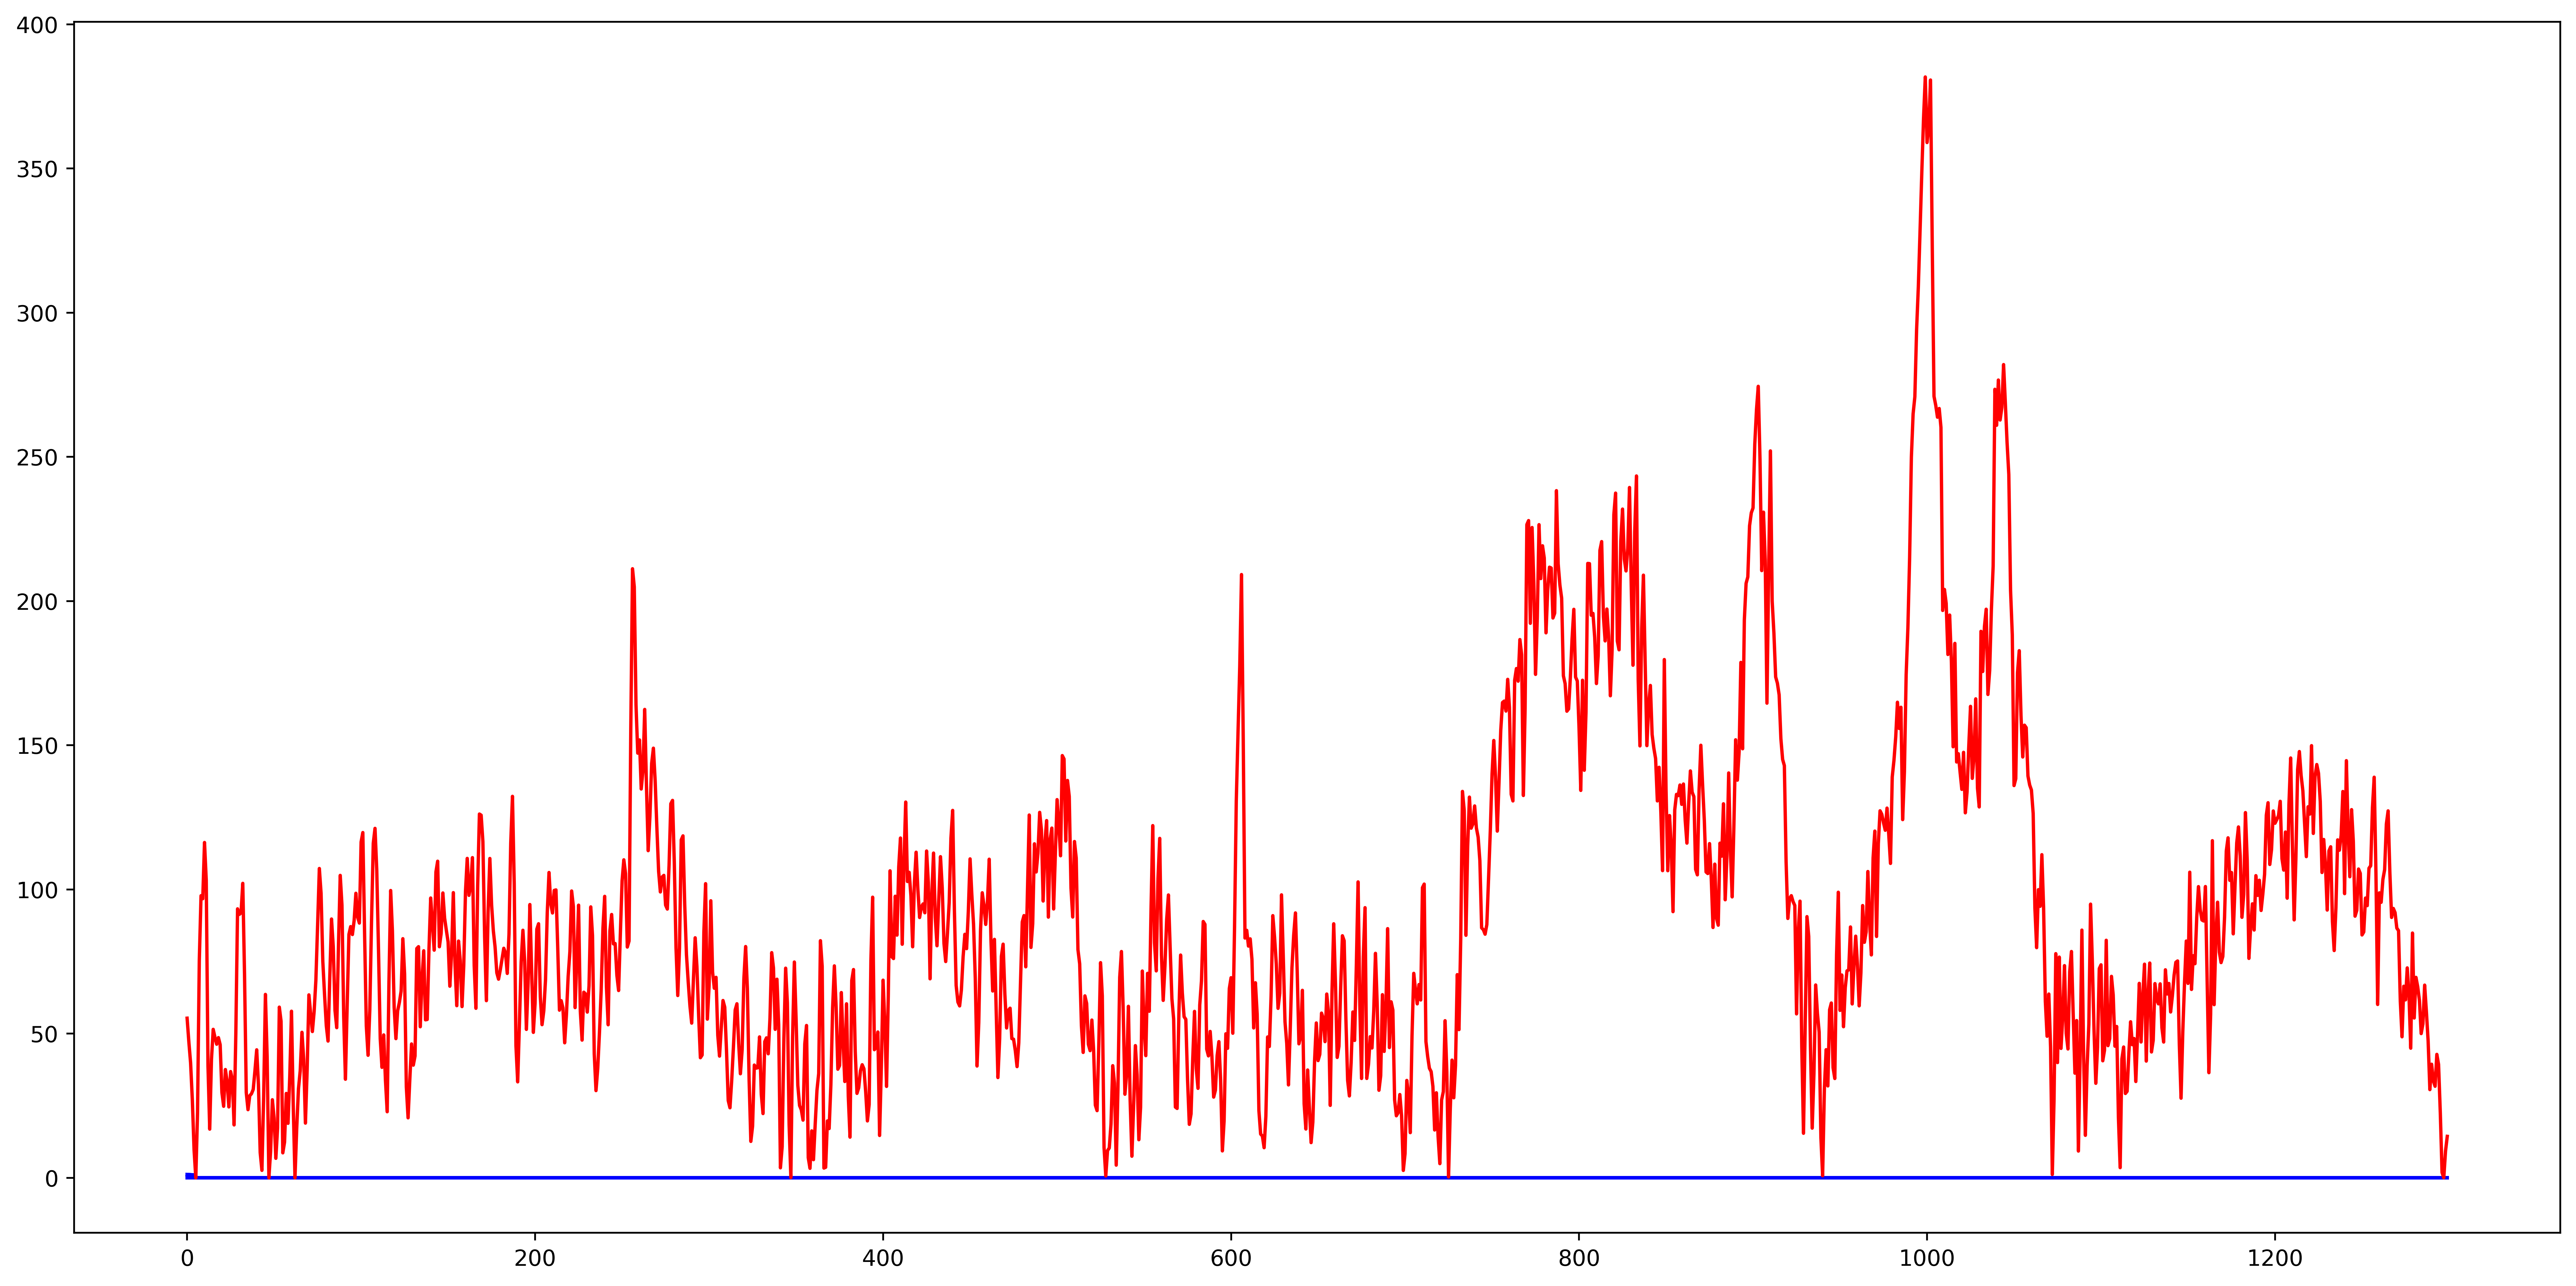

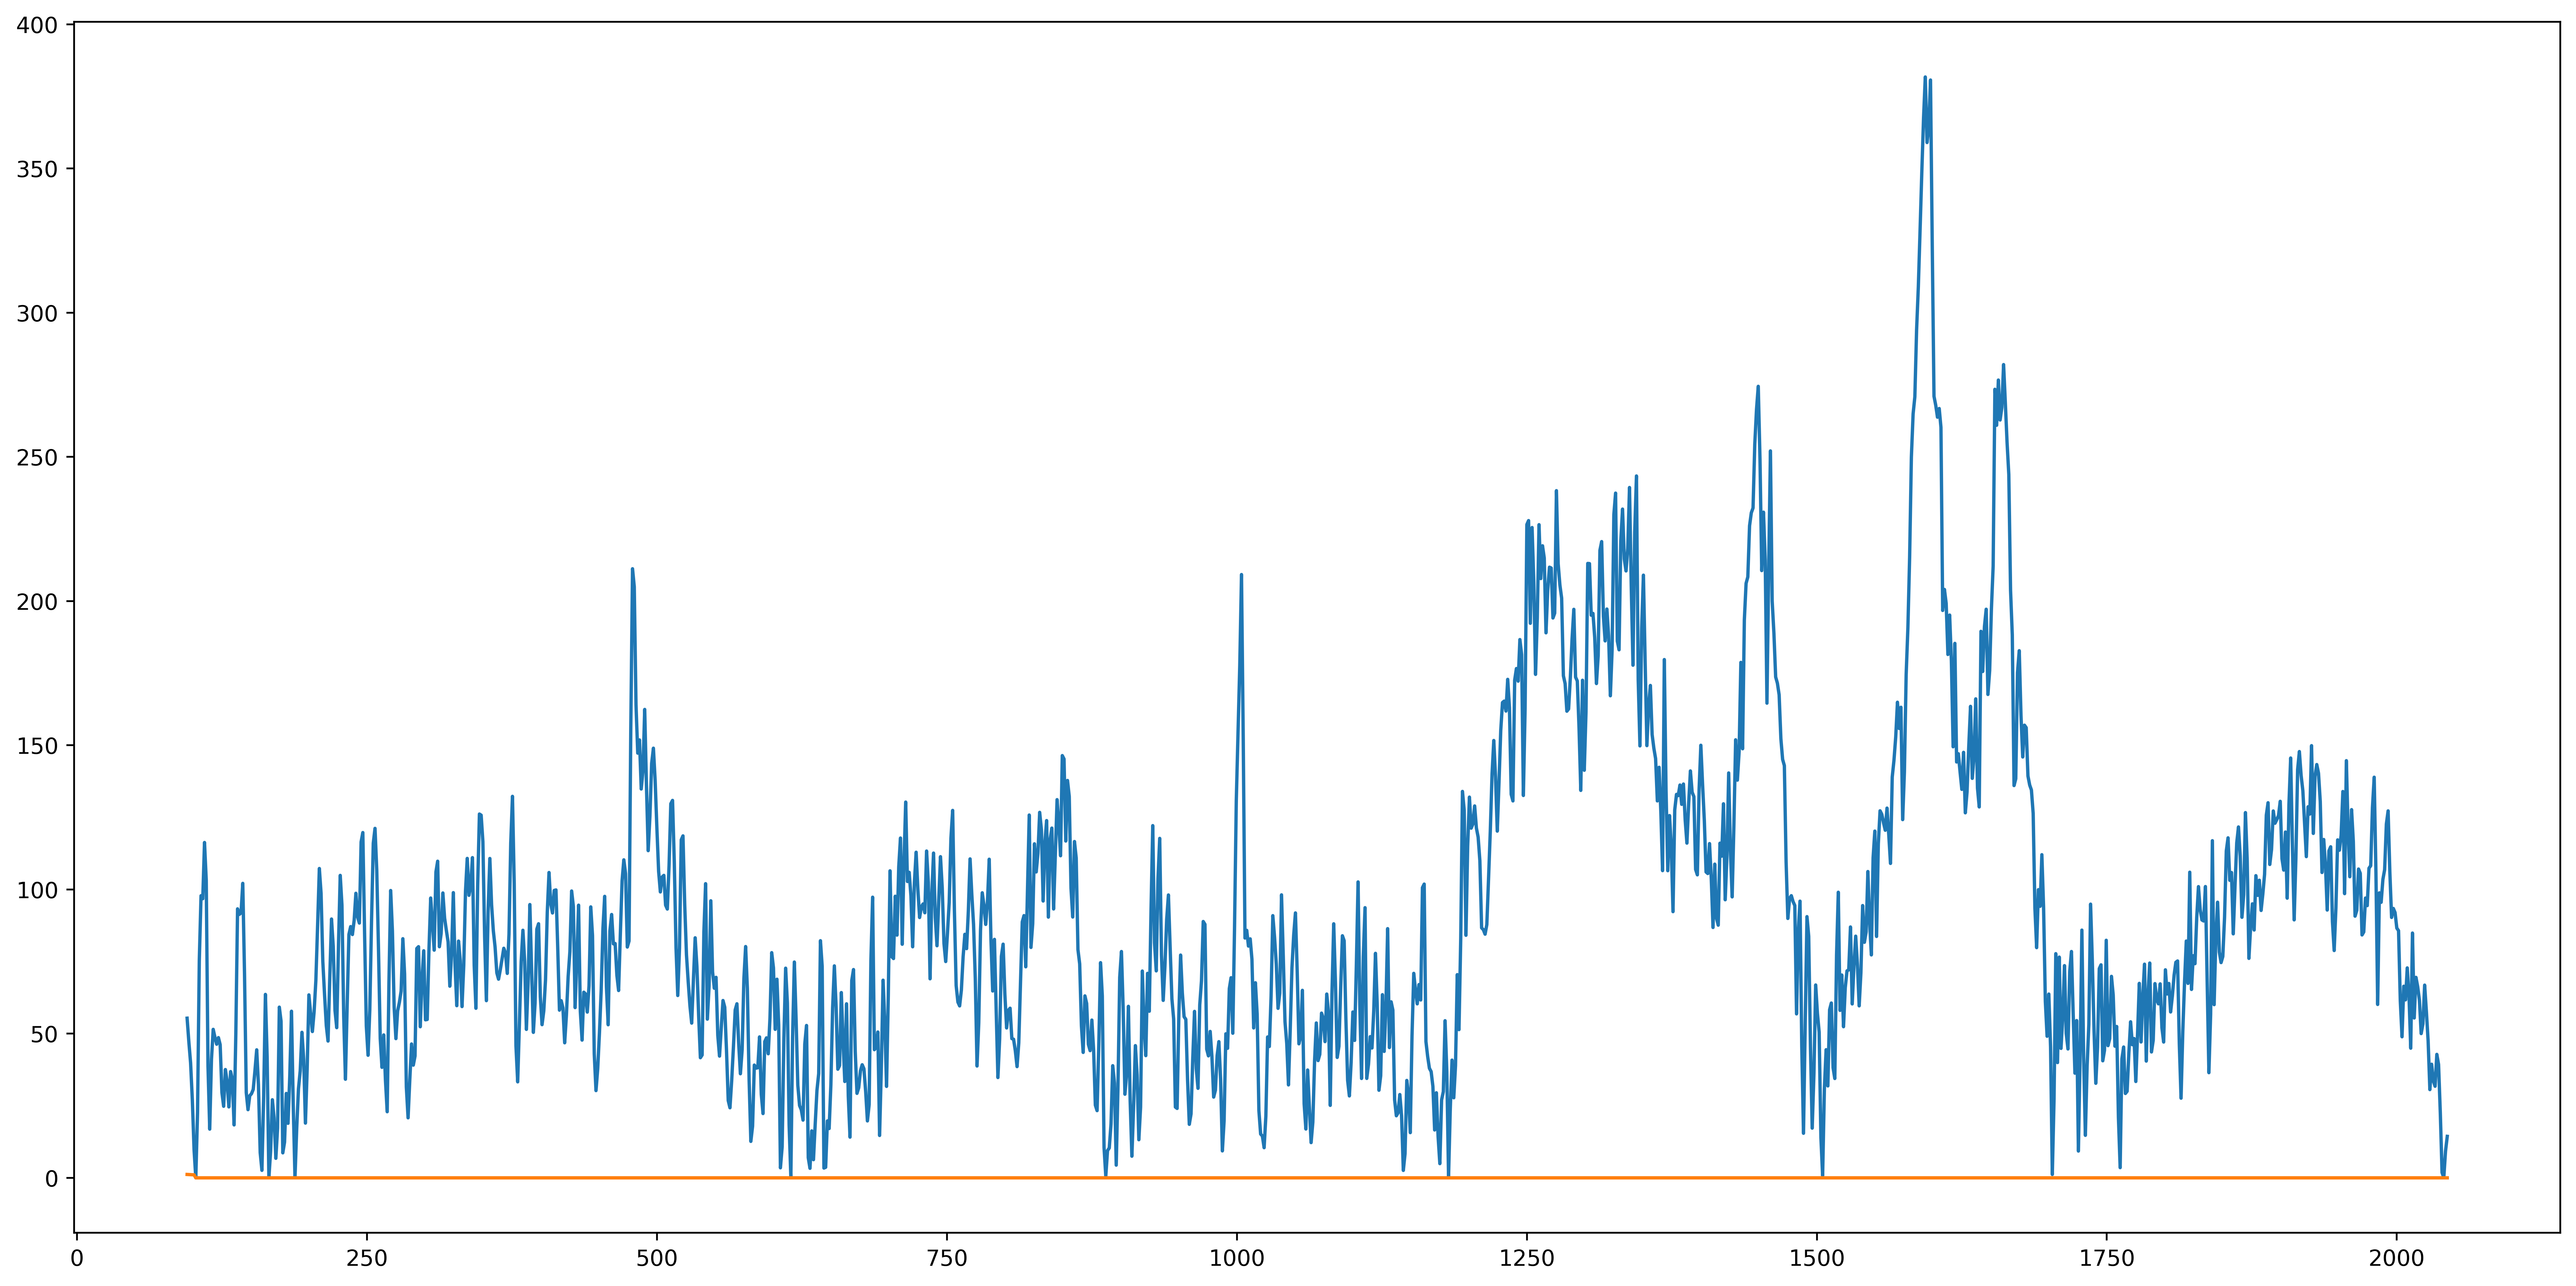

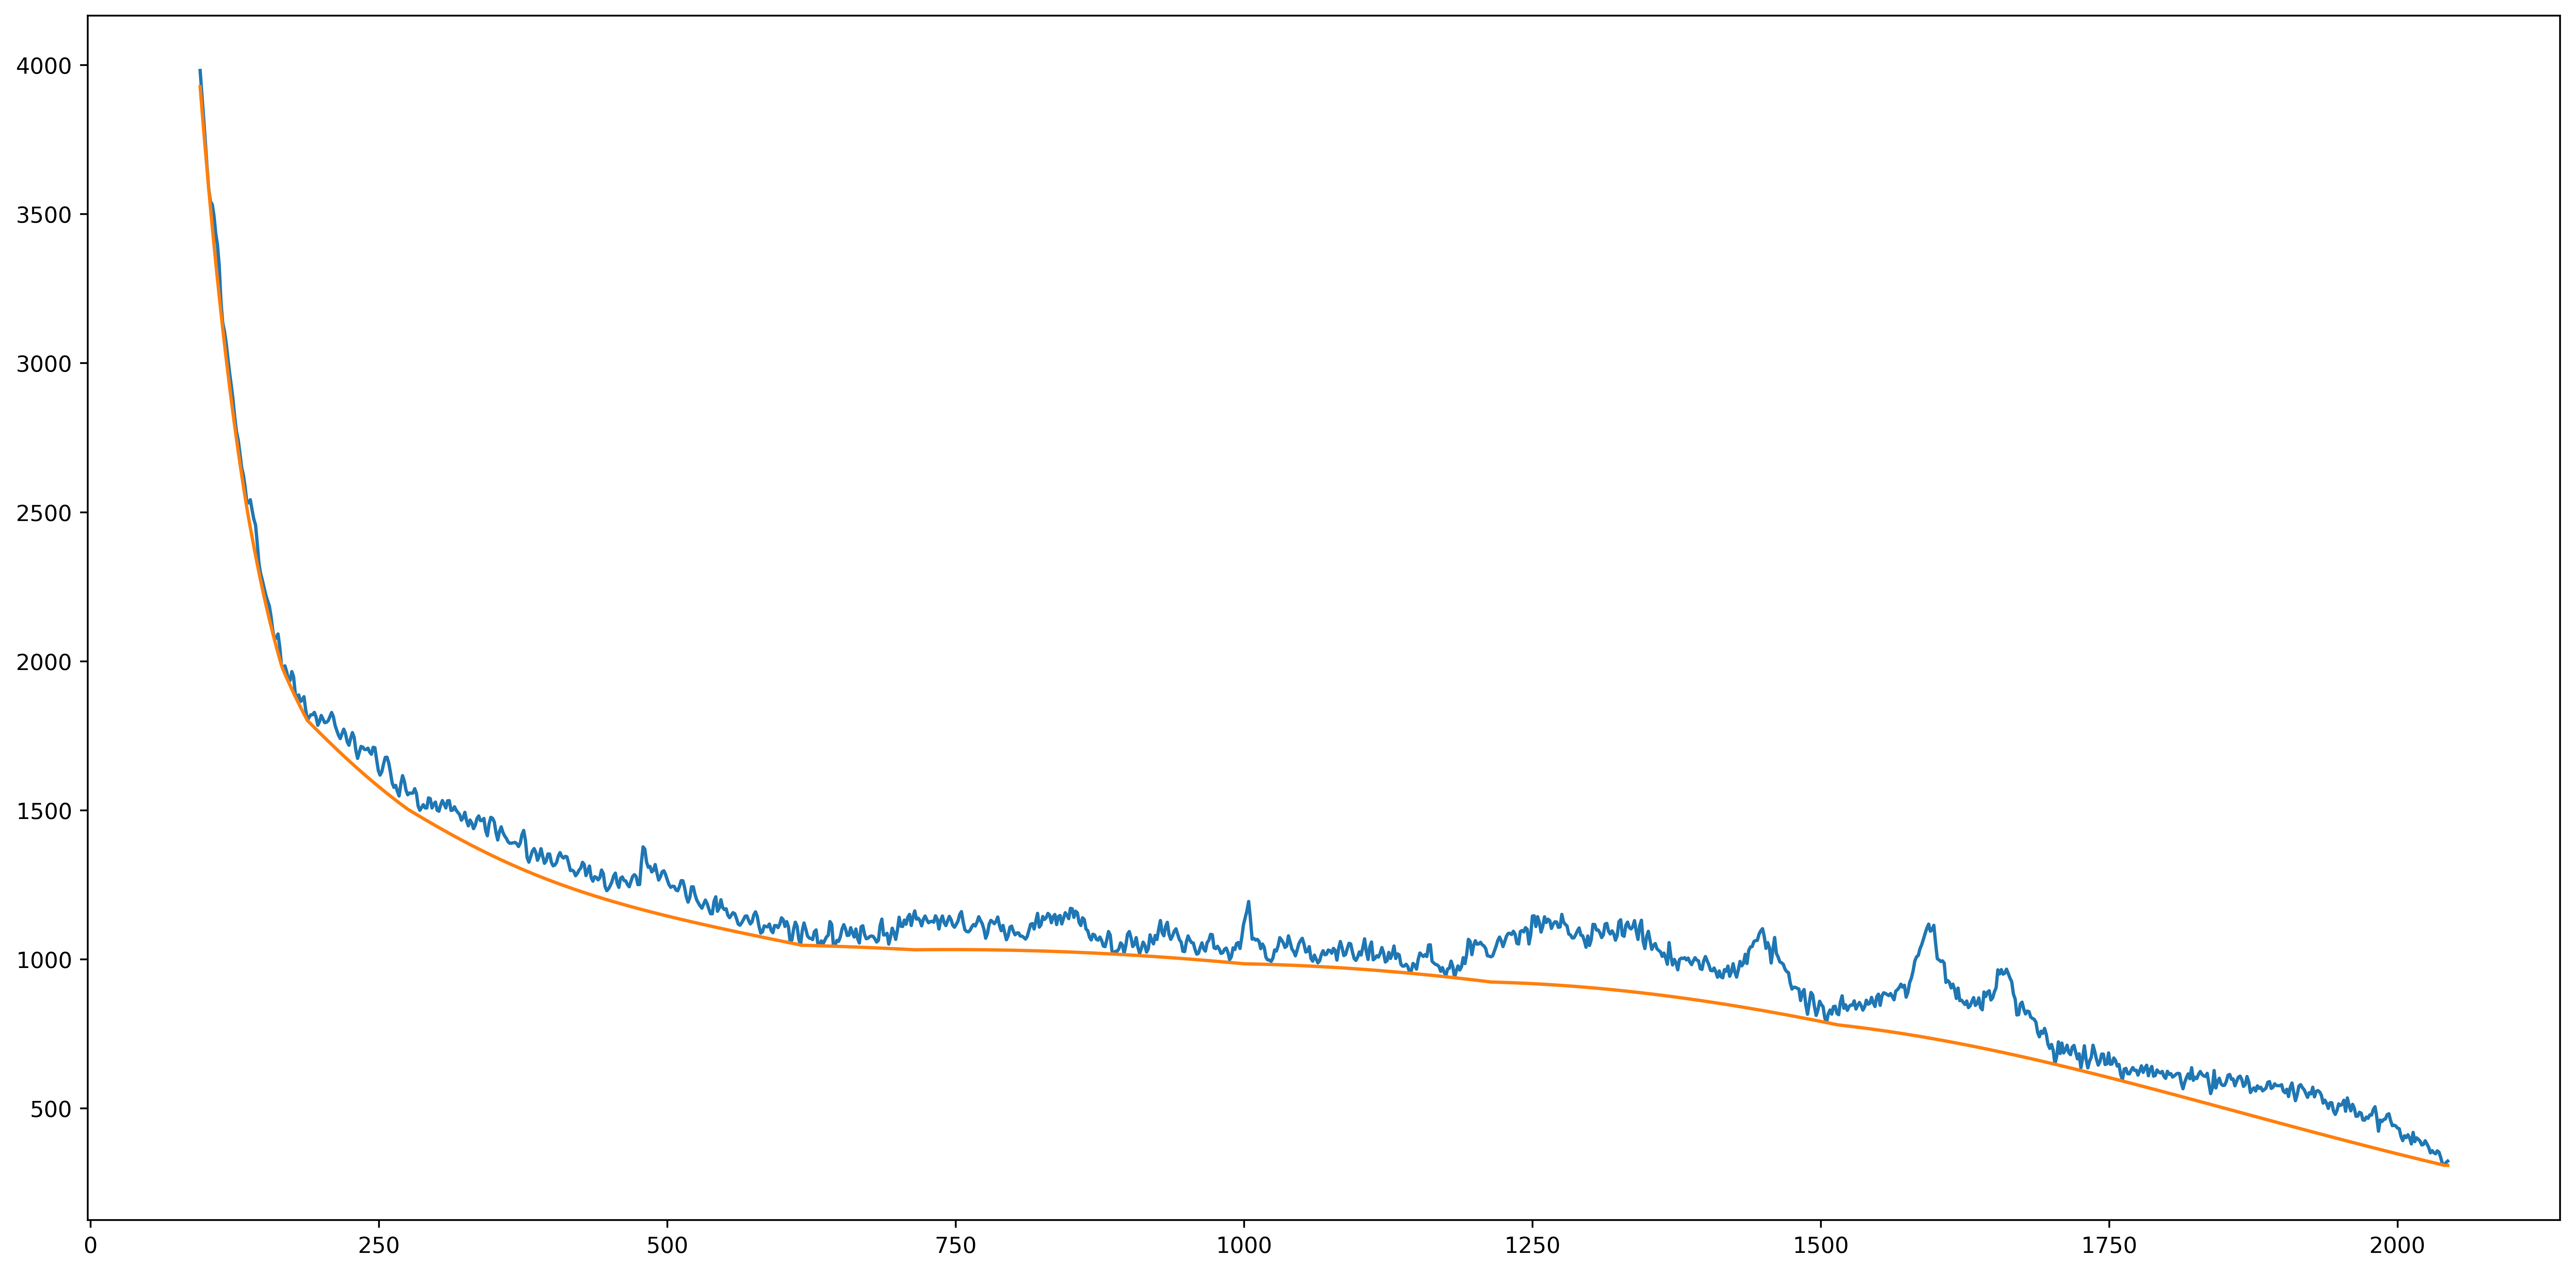

pixel: 2506


TypeError: cannot unpack non-iterable NoneType object

In [48]:
import timeit
from os import path

# file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
# os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

#     if j < 7:
#         continue
    
    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
#     print(f"image: {f} is done.")